### 1. Data Exploration & Pre-Processing

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!unzip /content/"SMU DSA Society x Maersk Case Competition 2023 Datasets.zip" -d dataset

In [ ]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

csv_file_path = '/content/dataset/Airline Passenger Satisfaction.csv'
csv_file_path_voices = '/content/dataset/Voice of Customer.csv'
voice = pd.read_csv(csv_file_path_voices)
airline = pd.read_csv(csv_file_path)

In [ ]:
print(airline.info());print(airline.head())

## Clean Airline DataFrame

### Renaming and Rearranging Columns: airline_arranged

Columns are arranged as such:
1) Independent Variables - Characteristics of passenger and flight taken
2) Dependent Variable - Customer loyalty and satisfaction scores
3) Dependent Variable - Satisfaction levels of various variables

In [ ]:
# set index
airline = airline.set_index("id")
airline = airline.iloc[:,1:]

# convert columns to category data type for memory efficiency
airline_categorical = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
airline[airline_categorical] = airline[airline_categorical].astype('category')

# age segmentation
age_bin_edges = [-1, 17, 35, 60, 100]
age_bin_labels = ['Child', 'Young Adult', 'Adult', 'Senior']
airline['Age Group'] = pd.cut(airline['Age'], bins=age_bin_edges, labels=age_bin_labels, right=False)

# distance segmentation
distance_bin_edges = [-1, 1499, 3500, 9000]
distance_bin_labels = ['Short-Haul', 'Medium-Haul', 'Long-Haul']
airline['Flight Length'] = pd.cut(airline['Flight Distance'], bins=distance_bin_edges, labels=distance_bin_labels, right=False)

# Departure/Arrival Delay
airline['Departure/Arrival delay'] = airline['Arrival Delay in Minutes'] + airline['Departure Delay in Minutes']

# Satisfaction
satisfaction_bin_edges = [-1, 4, 6, 8, 11]
satisfaction_bin_labels = ['Highly Dissatisfied', 'Dissatisfied', 'Neutral', 'Highly Satisfied']
airline['Satisfaction'] = pd.cut(airline['satisfaction score'], bins=satisfaction_bin_edges, labels=satisfaction_bin_labels, right=False)

# drop columns
airline.drop(columns=['Age','Flight Distance','Arrival Delay in Minutes','Departure Delay in Minutes', 'satisfaction'], inplace=True)

# Create a dictionary to map the current column names to their capitalized versions
capitalized_column_names = {col: col.capitalize() for col in airline.columns}

# Rename the columns using the dictionary
airline.rename(columns=capitalized_column_names, inplace=True)

# Create a dictionary to map the old values to the new values
replace_customertype = {"Loyal Customer": "Loyal", "disloyal Customer": "Disloyal"}
replace_typeoftravel = {"Personal Travel": "Personal", "Business travel":"Business"}

# Use the replace() method to change the values in the "Customer Type" column
airline["Customer type"] = airline["Customer type"].replace(replace_customertype)
airline["Type of travel"] = airline["Type of travel"].replace(replace_typeoftravel)

# Specify the desired order of columns
column_order = ['Gender', 'Age group', 'Type of travel', 'Class', 'Flight length', 'Departure/arrival delay',
                   'Customer type', 'Satisfaction score', 'Satisfaction']

# Reorder the columns in the DataFrame
airline_arranged = airline[column_order + [col for col in airline.columns if col not in column_order]]
airline_arranged = airline_arranged.sort_values('id', ascending=True)

### Rescaling

In [ ]:
def scale_column_reverse(df, col_name, new_min, new_max):
    col_min = df[col_name].min()
    col_max = df[col_name].max()
    df_scaled = df.copy()
    df_scaled[col_name] = (col_max - df_scaled[col_name]) / (col_max - col_min) * (new_max - new_min) + new_min
    return df_scaled

airline_arranged = scale_column_reverse(airline_arranged, 'Departure/arrival delay', 0, 5)

# Correlation Analysis and Identifying Key Drivers of Satisfaction Score

### Import Necessary Packages

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

import random
import logging

logging.getLogger('lightgbm').setLevel(logging.ERROR)

# Add a NullHandler to redirect the LightGBM library output to oblivion
lightgbm_logger = logging.getLogger('lightgbm')
lightgbm_logger.addHandler(logging.NullHandler())


import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Build Pipeline Functions

### Separate Numerical and Categorical Features

In [ ]:
#separate numerical and categorical features
numerical_features = ['Inflight wifi service',
                      'Departure/arrival time convenient',
                      'Ease of online booking',
                      'Gate location',
                      'Food and drink',
                      'Online boarding',
                      'Seat comfort',
                      'Inflight entertainment',
                      'On-board service',
                      'Leg room service',
                      'Baggage handling',
                      'Checkin service',
                      'Inflight service',
                      'Cleanliness',
                      'Departure/arrival delay'] #<-- Primary Independent Variable



categorical_features = ['Gender',
                        'Age group',
                        'Type of travel',
                        'Flight length',
                        'Customer type']


target = ['Satisfaction score']


### Function to Segment DataFrame and Identify High Collinearity

In [ ]:
def segment(segment, column, dataframe, threshold=0.8):
    # Subset DataFrame by Customer Segmentation: Customer Type
    name = dataframe[dataframe[column] == segment]

    # Create a copy of airline_segmented
    copy_name = name.copy()

    # Prepare Data with One-Hot Encoding
    copy_name = pd.get_dummies(copy_name, columns=categorical_features, drop_first=True).drop(['Satisfaction', column], axis=1)

    # Rearrange Satisfaction score column to the right
    column_satisfaction = ['Satisfaction score']
    copy_name = copy_name[[col for col in copy_name.columns if col not in column_satisfaction] + column_satisfaction]

    # Identify Collinearity
    subset_data = copy_name.iloc[:, :23]

    # Calculate the correlation matrix
    corr_matrix = subset_data.corr()

    # Create the heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

     # Find highly correlated feature pairs
    correlated_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                correlated_features.add((colname_i, colname_j))

    # Print the columns to remove due to collinearity
    if correlated_features:
        print("Columns to remove due to collinearity:")
        for col_pair in correlated_features:
            print(col_pair)
    else :
        print("No Columns with extremely high collinearity.")

    return(copy_name)

### Function to Remove Variables with Low Correlation

In [ ]:
def high_correlation_filter(dataframe, target_column, threshold):
    # Calculate the correlation matrix with the target variable
    corr_with_target = dataframe.corr()[target_column].abs().sort_values(ascending=False)

    # Select features with correlation above the threshold (excluding the target column)
    selected_features = corr_with_target[corr_with_target >= threshold].index.tolist()
    selected_features.remove(target_column)  # Remove the target variable from selected features

    # Create a new DataFrame with the selected features and the target column
    selected_features_df = dataframe[selected_features + [target_column]]

    # Print the columns removed during feature selection
    removed_features = set(dataframe.columns) - set(selected_features_df.columns)
    print("Columns removed:")
    for col in removed_features:
        print(col)

    return selected_features_df

#### Class == "Business"

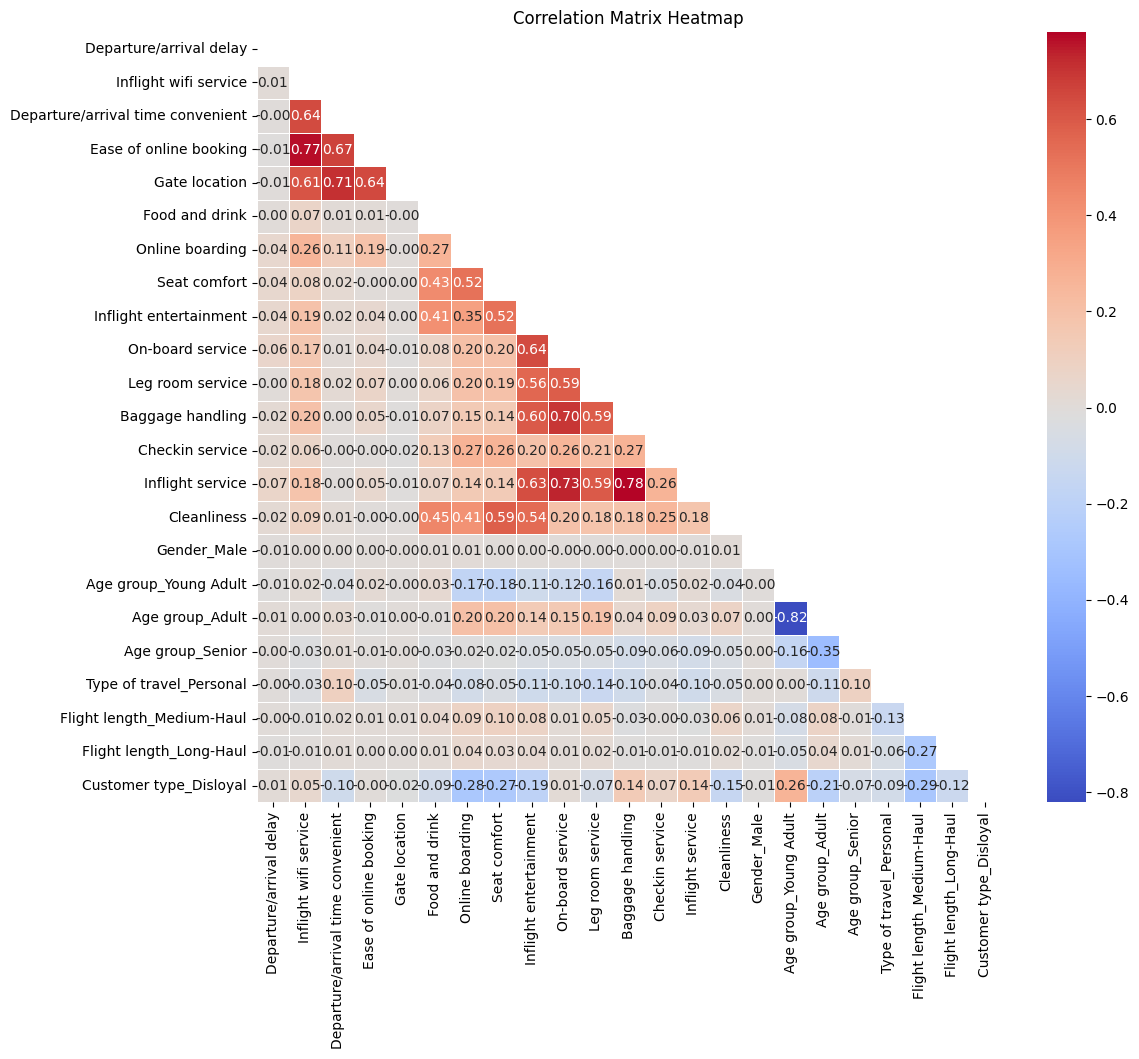

Columns to remove due to collinearity:
('Age group_Adult', 'Age group_Young Adult')
Columns removed:
Flight length_Medium-Haul
Flight length_Long-Haul
Departure/arrival time convenient
Departure/arrival delay
Gate location
Gender_Male
Age group_Senior


In [ ]:
business_hot = segment("Business", "Class", airline_arranged)

business_hot_filtered = high_correlation_filter(business_hot, 'Satisfaction score', 0.1)

#### Class == 'Eco Plus'

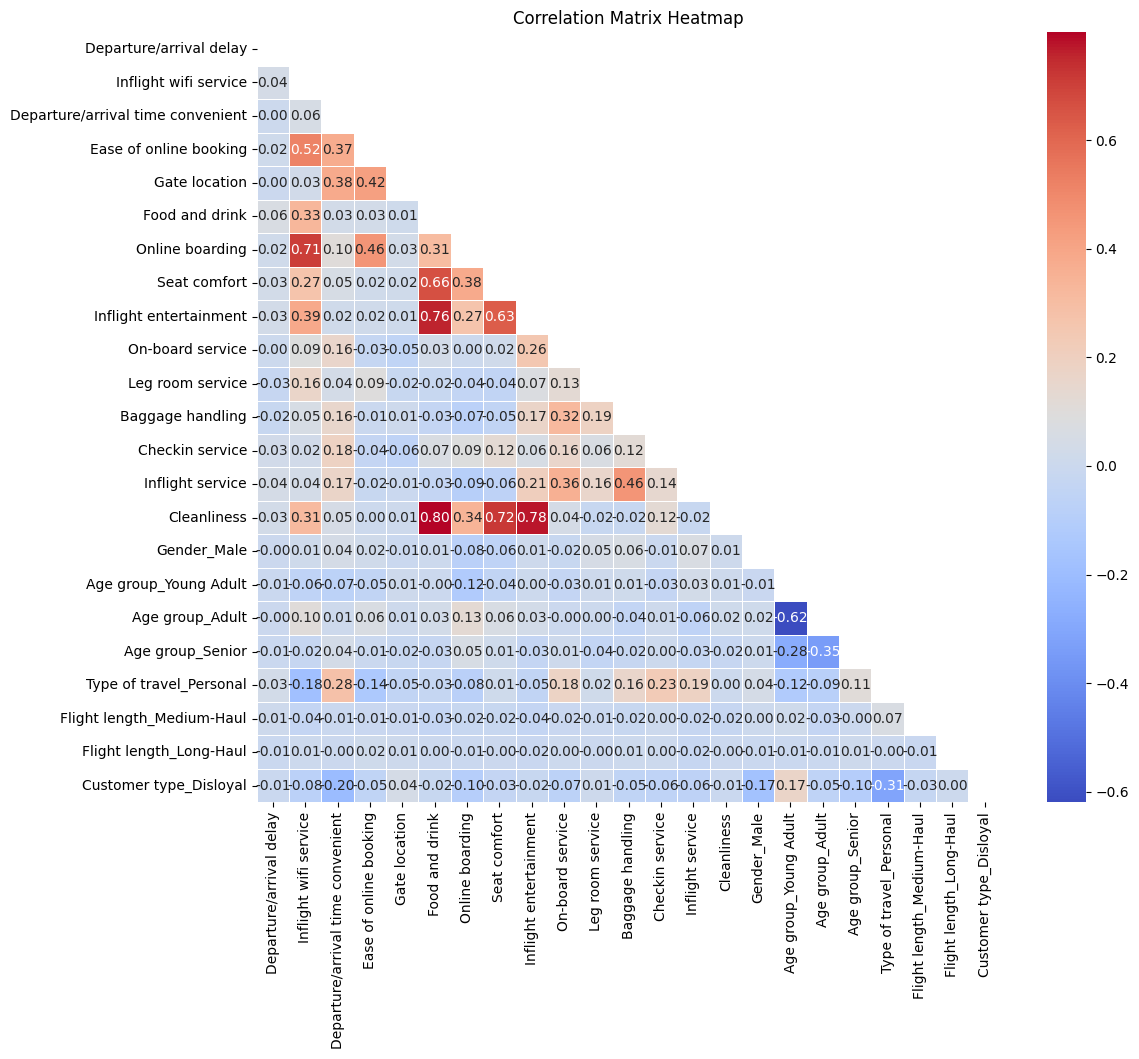

No Columns with extremely high collinearity.
Columns removed:
Flight length_Medium-Haul
Flight length_Long-Haul
Departure/arrival delay
Age group_Young Adult
Age group_Adult
Gate location
Gender_Male
Age group_Senior


In [ ]:
ecoplus_hot = segment("Eco Plus", "Class", airline_arranged)

ecoplus_hot_filtered = high_correlation_filter(ecoplus_hot, 'Satisfaction score', 0.1)

#### Class == 'Eco'

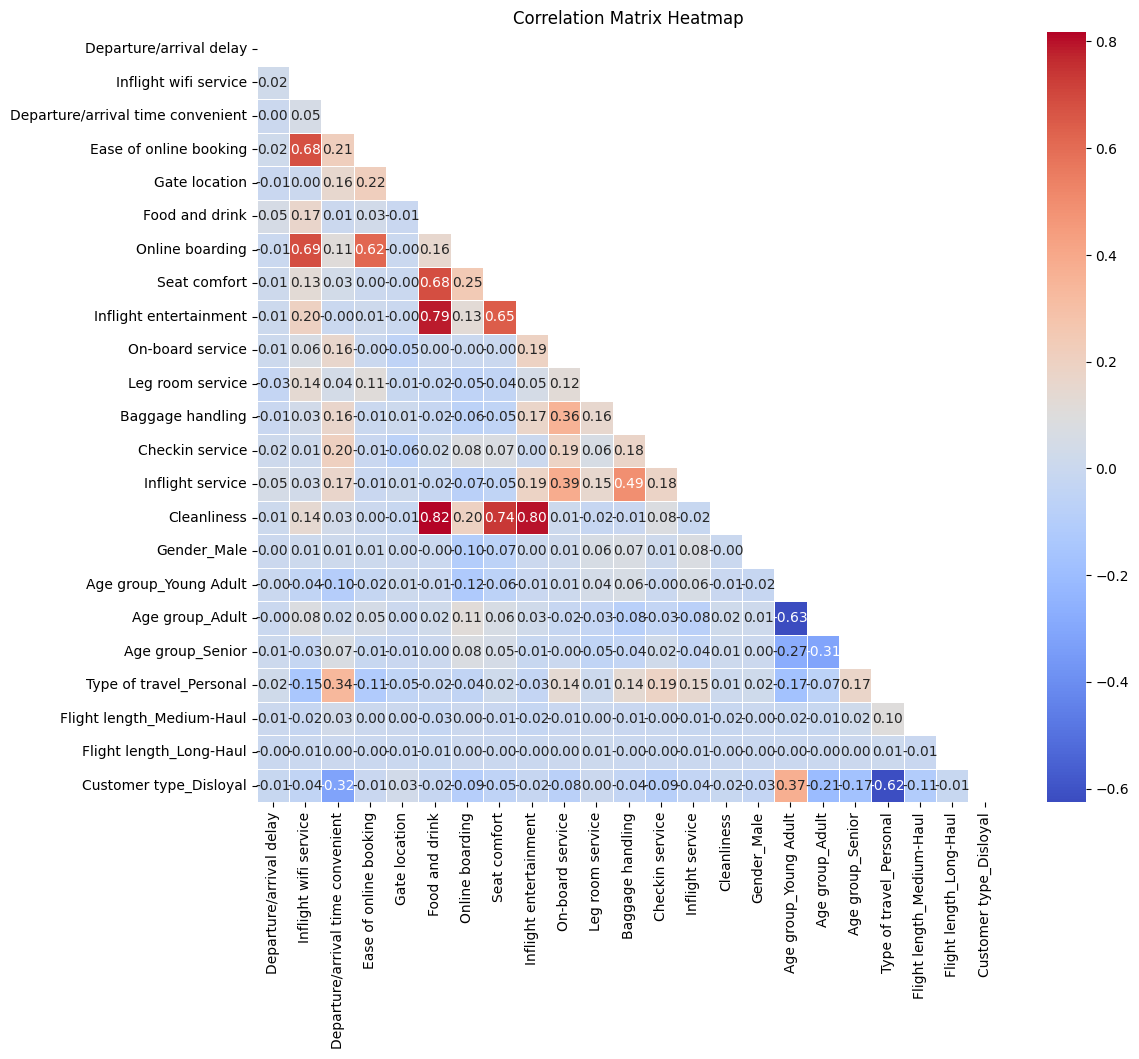

Columns to remove due to collinearity:
('Cleanliness', 'Food and drink')
Columns removed:
Flight length_Medium-Haul
Flight length_Long-Haul
Departure/arrival delay
Age group_Young Adult
Type of travel_Personal
Age group_Adult
Gate location
Gender_Male
Age group_Senior


In [ ]:
eco_hot = segment("Eco", "Class", airline_arranged)

eco_hot_filtered = high_correlation_filter(eco_hot, 'Satisfaction score', 0.1)

# Model Selection & Parameter Tuning

### Build Function for Model Selection

In [ ]:
def run_regression_models(data, test_size=0.2, random_state=2023):
    X = data.drop('Satisfaction score', axis=1)  # Features (independent variables)
    y = data['Satisfaction score']  # Target variable (dependent variable)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize regression models
    models = [
        LinearRegression(),
        RandomForestRegressor(),
        GradientBoostingRegressor(),
        SVR(),
        KNeighborsRegressor(),
        LGBMRegressor(),
        XGBRegressor()
    ]

    for model in models:
        model_name = type(model).__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r_squared = r2_score(y_test, y_pred)

        print(f"Model: {model_name}")
        print("Mean Squared Error (MSE):", mse)
        print("Root Mean Squared Error (RMSE):", rmse)
        print("R-squared:", r_squared)
        print("---------------------------")

### Model Selection & Parameter Tuning for *business_hot_filtered*

In [ ]:
run_regression_models(business_hot_filtered, 0.2)
# Best Model: XGBRegressor

Model: LinearRegression
Mean Squared Error (MSE): 2.009810759344571
Root Mean Squared Error (RMSE): 1.4176779462714975
R-squared: 0.5473099723416831
---------------------------
Model: RandomForestRegressor
Mean Squared Error (MSE): 0.6868845718274217
Root Mean Squared Error (RMSE): 0.8287849973469728
R-squared: 0.845286032840211
---------------------------
Model: GradientBoostingRegressor
Mean Squared Error (MSE): 0.925343034152764
Root Mean Squared Error (RMSE): 0.9619475215170337
R-squared: 0.7915756188604279
---------------------------
Model: SVR
Mean Squared Error (MSE): 0.9429489717750453
Root Mean Squared Error (RMSE): 0.9710555966447263
R-squared: 0.7876100552609077
---------------------------
Model: KNeighborsRegressor
Mean Squared Error (MSE): 0.9043307593307592
Root Mean Squared Error (RMSE): 0.9509630693832223
R-squared: 0.7963084262782962
---------------------------
Model: LGBMRegressor
Mean Squared Error (MSE): 0.6600170882391716
Root Mean Squared Error (RMSE): 0.812414357

#### Parameter Tuning for *business_hot_filtered* - XGBRegressor

###### Create Function for Parameter Tuning - XGBRegressor

In [ ]:
def xgb_parameter_tuning(dataframe, target, test_size, random_state):
    """Conducts parameter tuning for the given dataframe through the model XGBRegressor"""

    # Prepare the data and split into features (X) and target (y)
    X = dataframe.drop(columns=[target])
    y = dataframe[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Define the Hyperparameter Grid
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Perform Randomized Search with Cross-Validation
    xgb_model = XGBRegressor(random_state=random_state)
    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10,
                                       scoring='neg_mean_squared_error', cv=5, random_state=random_state)
    random_search.fit(X_train, y_train)

    # Identify the Best Hyperparameters
    best_params = random_search.best_params_

    # Train the Final Model with Best Hyperparameters
    final_xgb_model = XGBRegressor(**best_params, random_state=random_state)
    final_xgb_model.fit(X_train, y_train)

    # Evaluate the Final Model on the Test Set
    y_pred = final_xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r_squared = r2_score(y_test, y_pred)

    print("Best Hyperparameters:", best_params)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared:", r_squared)

    return final_xgb_model

In [ ]:
# Input Final XGBRegressor Model into business_final
business_final = xgb_parameter_tuning(business_hot_filtered, 'Satisfaction score', 0.5, 2023)

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Root Mean Squared Error (RMSE): 0.8077011703541928
R-squared: 0.8541011838038057


#### Model Output & Feature Importance

###### Create Function for Final XGB Model Evaluation

In [ ]:
def evaluate_xgb_model(final_model, dataframe, target, test_size=0.2, random_state=2023):
    # Split the data into features (X) and target (y)
    X = dataframe.drop(columns=[target])
    y = dataframe[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Make predictions on the test set using the final_model
    y_pred = final_model.predict(X_test)

    # Plot the graph of actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='b', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.show()

    # Calculate evaluation metrics (e.g., MSE, RMSE, R-squared)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r_squared = r2_score(y_test, y_pred)

    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared:", r_squared)

    # Extract feature importances
    if isinstance(final_model, XGBRegressor):
        importance_scores = final_model.feature_importances_
        feature_importances = dict(zip(X.columns, importance_scores))

        # Print feature importances in descending order
        print("Feature Importances:")
        for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
            print(f"{feature}: {importance}")
    else:
        print("Feature Importances are not available for this model.")

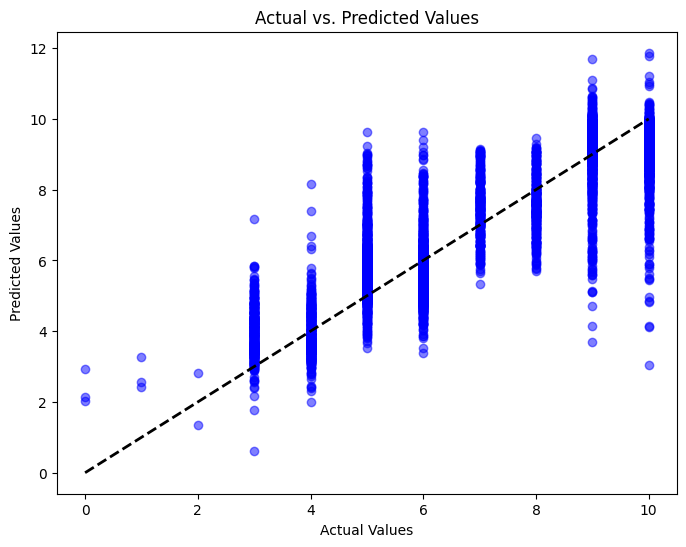

Root Mean Squared Error (RMSE): 0.8091396214974519
R-squared: 0.852533729581958
Feature Importances:
Online boarding: 0.2465147227048874
Inflight entertainment: 0.18678992986679077
Type of travel_Personal: 0.13357706367969513
Inflight wifi service: 0.11196423321962357
Customer type_Disloyal: 0.06759309023618698
Cleanliness: 0.03872374817728996
Checkin service: 0.03441547229886055
Leg room service: 0.03249109908938408
Ease of online booking: 0.027939572930336
On-board service: 0.026115087792277336
Seat comfort: 0.02528422698378563
Inflight service: 0.021351685747504234
Baggage handling: 0.018326953053474426
Age group_Young Adult: 0.010623902082443237
Food and drink: 0.010502535849809647
Age group_Adult: 0.0077866846695542336


In [ ]:
# Print out Final Model Evaluation
evaluate_xgb_model(business_final, business_hot_filtered, 'Satisfaction score', 0.2)

### Model Selection & Parameter Tuning for *ecoplus_hot_filtered*

In [ ]:
run_regression_models(ecoplus_hot_filtered, 0.2)
# Best Model: LGBMRegressor

Model: LinearRegression
Mean Squared Error (MSE): 2.0913891889140834
Root Mean Squared Error (RMSE): 1.4461636107004225
R-squared: 0.5355128507682628
---------------------------
Model: RandomForestRegressor
Mean Squared Error (MSE): 1.149008594652988
Root Mean Squared Error (RMSE): 1.0719181846824821
R-squared: 0.7448108991850315
---------------------------
Model: GradientBoostingRegressor
Mean Squared Error (MSE): 1.1821338408038575
Root Mean Squared Error (RMSE): 1.087259785333688
R-squared: 0.7374539465748835
---------------------------
Model: SVR
Mean Squared Error (MSE): 1.3796744371685141
Root Mean Squared Error (RMSE): 1.174595435530257
R-squared: 0.6935811614666278
---------------------------
Model: KNeighborsRegressor
Mean Squared Error (MSE): 1.570387679235263
Root Mean Squared Error (RMSE): 1.2531510999218183
R-squared: 0.6512246978309322
---------------------------
Model: LGBMRegressor
Mean Squared Error (MSE): 1.0201178079442392
Root Mean Squared Error (RMSE): 1.0100088157

#### Parameter Tuning for *ecoplus_hot_filtered* - LGBMRegressor

###### Create Function for Parameter Tuning - LGBMRegressor

In [ ]:
def lgbm_parameter_tuning(dataframe, target, test_size, random_state):
    """Conducts parameter tuning for the given dataframe through the model LGBMRegressor"""

    # Prepare the data and split into features (X) and target (y)
    X = dataframe.drop(columns=[target])
    y = dataframe[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Define the Hyperparameter Grid
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'num_leaves': [15, 31, 63],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Perform Randomized Search with Cross-Validation
    lgbm_model = lgb.LGBMRegressor(random_state=random_state)
    random_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid, n_iter=10,
                                       scoring='neg_mean_squared_error', cv=5, random_state=random_state)
    random_search.fit(X_train, y_train)

    # Identify the Best Hyperparameters
    best_params = random_search.best_params_

    # Train the Final Model with Best Hyperparameters
    final_lgbm_model = lgb.LGBMRegressor(**best_params, random_state=random_state)
    final_lgbm_model.fit(X_train, y_train)

    # Evaluate the Final Model on the Test Set
    y_pred = final_lgbm_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r_squared = r2_score(y_test, y_pred)

    print("Best Hyperparameters:", best_params)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared:", r_squared)

    return final_lgbm_model

In [ ]:
# Input Final LGBMRegressor Model into ecoplus_final
ecoplus_final = lgbm_parameter_tuning(ecoplus_hot_filtered, 'Satisfaction score', 0.2, 2023)

Best Hyperparameters: {'subsample': 0.9, 'num_leaves': 63, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Root Mean Squared Error (RMSE): 1.0478618689551333
R-squared: 0.7561364350757281


#### Model Output & Feature Importance

###### Create Function for Final LGBM Model Evaluation

In [ ]:
def evaluate_lgbm_model(final_model, dataframe, target, test_size=0.2, random_state=2023):
    # Split the data into features (X) and target (y)
    X = dataframe.drop(columns=[target])
    y = dataframe[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Make predictions on the test set using the final_model
    y_pred = final_model.predict(X_test)

    # Plot the graph of actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='b', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.show()

    # Calculate evaluation metrics (e.g., MSE, RMSE, R-squared)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r_squared = r2_score(y_test, y_pred)

    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared:", r_squared)

    # Extract feature importances
    if isinstance(final_model, lgb.LGBMRegressor):
        importance_scores = final_model.feature_importances_
        feature_importances = dict(zip(X.columns, importance_scores))

        # Print feature importances in descending order
        print("Feature Importances:")
        for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
            print(f"{feature}: {importance}")
    else:
        print("Feature Importances are not available for this model.")

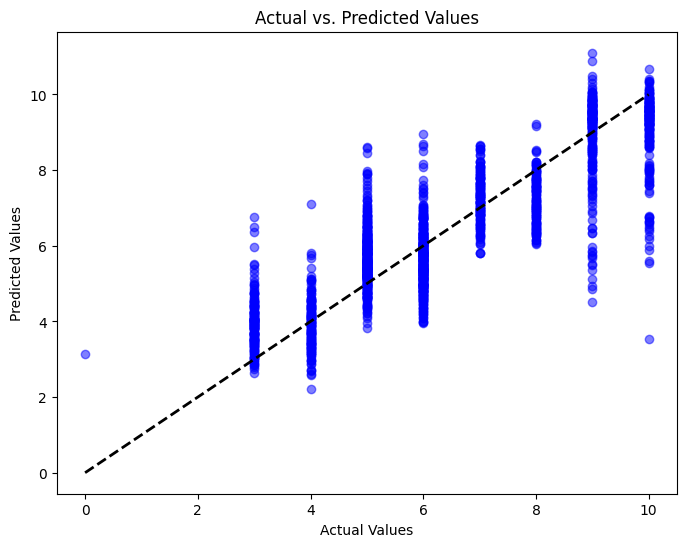

Root Mean Squared Error (RMSE): 1.0478618689551333
R-squared: 0.7561364350757281
Feature Importances:
Inflight service: 709
Baggage handling: 688
Inflight wifi service: 679
Checkin service: 619
Seat comfort: 599
Departure/arrival time convenient: 579
On-board service: 543
Ease of online booking: 507
Online boarding: 500
Inflight entertainment: 486
Leg room service: 484
Cleanliness: 450
Food and drink: 396
Type of travel_Personal: 369
Customer type_Disloyal: 156


In [ ]:
# Print out Final Model Evaluation
evaluate_lgbm_model(ecoplus_final, ecoplus_hot_filtered, 'Satisfaction score', 0.2)

### Model Selection & Parameter Tuning for *eco_hot_filtered*

In [ ]:
run_regression_models(eco_hot_filtered, 0.2)
# Best Model: XGBRegressor

Model: LinearRegression
Mean Squared Error (MSE): 2.042033106920286
Root Mean Squared Error (RMSE): 1.428997238247956
R-squared: 0.4799855621407967
---------------------------
Model: RandomForestRegressor
Mean Squared Error (MSE): 1.0920419257404057
Root Mean Squared Error (RMSE): 1.0450080984090055
R-squared: 0.7219057976052947
---------------------------
Model: GradientBoostingRegressor
Mean Squared Error (MSE): 1.199859371988057
Root Mean Squared Error (RMSE): 1.09538092551772
R-squared: 0.6944495195890951
---------------------------
Model: SVR
Mean Squared Error (MSE): 1.2501683294749668
Root Mean Squared Error (RMSE): 1.1181092654454514
R-squared: 0.6816380797754216
---------------------------
Model: KNeighborsRegressor
Mean Squared Error (MSE): 1.4098679471788715
Root Mean Squared Error (RMSE): 1.1873786031333358
R-squared: 0.640969734759276
---------------------------
Model: LGBMRegressor
Mean Squared Error (MSE): 1.0700665732445043
Root Mean Squared Error (RMSE): 1.034440222170

#### Parameter Tuning for *eco_hot_filtered* - XGBRegressor

In [ ]:
# Input Final XGBRegressor Model into eco_final
eco_final = xgb_parameter_tuning(eco_hot_filtered, 'Satisfaction score', 0.2, 2023)

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Root Mean Squared Error (RMSE): 1.0134091809295118
R-squared: 0.7384695315658486


#### Model Output & Feature Importance

In [ ]:
# Print out Final Model Evaluation
evaluate_xgb_model(eco_final, eco_hot_filtered, 'Satisfaction score', 0.2)